# 神经网络的通用近似定理（Universal Approximation Theorem）
## pytorch实现
>对于任何连续函数f: Rⁿ → R 和任意ε > 0  
存在一个包含单隐藏层的前馈神经网络，其输出与f的误差不超过ε  
ReLU的线性区段组合可以形成分段线性近似

**在本题中，通过组合多个ReLU激活的线性变换，网络可以构建足够多的"折线段"来逼近x²曲线。随着隐藏层神经元数量的增加，近似精度会不断提高。**  
选择的目标函数是x²，属于典型的非线性函数，可以很好地测试网络的拟合能力。

In [35]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# 本人完成作业时使用的是自己的轻薄本电脑，安装的是CPU版本的pytorch
device = 'cpu'

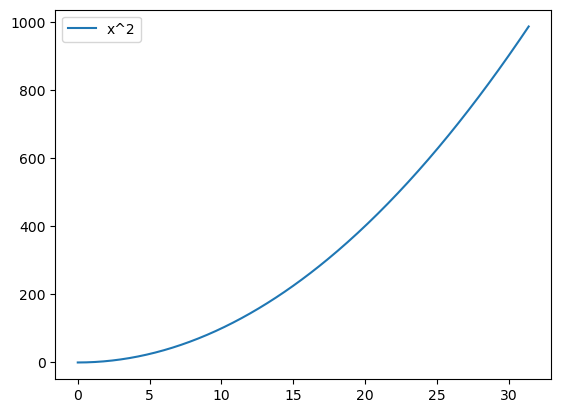

In [36]:
def targetFunc(x):
    """目标函数：x²的平方函数"""
    return x * x

# 生成密集采样点用于可视化
x = np.arange(0, 10 * np.pi, 0.1)  # 生成0-10π的密集数据点
plt.plot(x, [targetFunc(i) for i in x])
plt.legend(["x^2"])

In [37]:
# 生成实际训练数据（更密集的采样）
x = np.arange(0, 5 * np.pi, 0.001)  # 0-5π范围内生成训练数据
y = [targetFunc(i) for i in x]

# 数据集划分（训练：验证：测试 = 7:1:2）
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=1)

In [38]:
class CurveDataset(Dataset):
    """自定义曲线数据集类，继承自PyTorch的Dataset"""
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.tensor(X)  # 输入特征转换为张量
        self.y = torch.tensor(y)  # 目标值转换为张量

    def __getitem__(self, idx):
        """获取单个样本，需要返回(input, target)对"""
        return self.X[idx], self.y[idx]

    def __len__(self):
        """返回数据集总长度"""
        return len(self.y)

In [39]:
train_dataset = CurveDataset(X_train, y_train)
val_dataset = CurveDataset(X_val, y_val)
test_dataset = CurveDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [40]:
# 神经网络模型定义
class MLP(nn.Module):
    """两层全连接网络（输入层->隐藏层->输出层）"""
    def __init__(self, in_features=1, out_features=1):
        super().__init__()
        # 第一层：输入维度1，输出维度10
        self.FC1 = nn.Linear(in_features=in_features, out_features=10)
        # 使用ReLU激活函数   引入非线性能力
        self.relu = nn.ReLU()
        # 第二层：输入维度10，输出维度1
        self.FC2 = nn.Linear(in_features=10, out_features=out_features)

    def forward(self, x):
        x = self.FC1(x)
        x = self.relu(x)
        outputs = self.FC2(x)
        return outputs

model = MLP()
model

MLP(
  (FC1): Linear(in_features=1, out_features=10, bias=True)
  (relu): ReLU()
  (FC2): Linear(in_features=10, out_features=1, bias=True)
)

In [41]:
# 权重初始化函数
def weights_init(m):
    """自定义权重初始化：使用正态分布初始化全连接层权重"""
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight.data, 0.0, 0.02)  # 均值为0，标准差为0.02

In [42]:
model.apply(weights_init)
loss_fn = nn.L1Loss()

In [43]:
# 验证函数
def val(model, dataloader, loss_fn, device='cpu'):
    """验证阶段函数"""
    model.to(device)
    model.eval()  # 设置评估模式（关闭dropout等）
    with torch.inference_mode():  # 关闭梯度计算
        rec_loss = 0
        for X, y in dataloader:
            # 数据预处理：增加通道维度并转换类型
            X = X.to(device).unsqueeze(-1).float()  # [batch] -> [batch, 1]
            y = y.to(device).unsqueeze(-1).float()
            # 前向计算
            logits = model(X)
            loss = loss_fn(logits, y)
            rec_loss += loss
        print(f"Validation loss:{rec_loss / len(dataloader)}")

# 训练函数
def training(model, dataloader, val_dataloader, loss_fn, lr=0.001, epochs=50, device='cpu', verbose_epoch=10):
    """训练流程主函数"""
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # 使用Adam优化器
    for epoch in tqdm(range(epochs)):
        model.train()   # 设置训练模式
        rec_loss = 0
        for X, y in dataloader:
            # 数据预处理
            X = X.to(device).unsqueeze(-1).float()
            y = y.to(device).unsqueeze(-1).float()

            # 前向传播
            logits = model(X)
            loss = loss_fn(logits, y)

            # 反向传播
            optimizer.zero_grad()  # 清空梯度
            loss.backward()        # 计算梯度
            optimizer.step()       # 更新参数

            rec_loss += loss

        if epoch % verbose_epoch == 0:
            print(f"Epoch{epoch}\tLoss{rec_loss / len(dataloader)}")
            val(model, val_dataloader, loss_fn, device)  # 执行验证


In [44]:
# 测试函数
def test(model, ranger, steper, loss_fn, device='cpu'):
    """测试与可视化函数"""
    model.to(device)
    model.eval()  # 设置评估模式（关闭dropout等）
    x = []
    y_pred = []
    with torch.inference_mode():
        rec_loss = 0
        # 生成连续测试点
        for X in range(ranger[0], ranger[1], steper):
            X = torch.tensor(X).to(device).unsqueeze(-1).float()
            y = torch.tensor([targetFunc(i) for i in X]).to(device).unsqueeze(-1).float()

            logits = model(X)
            loss = loss_fn(logits, y)
            rec_loss += loss

            x.extend(X.unsqueeze(1))
            y_pred.extend(logits.unsqueeze(1))
        print(f"Test loss:{rec_loss * steper / (ranger[1] - ranger[0])}")

    x = [i.cpu().numpy() for i in x]
    y_pred = [i.cpu().numpy() for i in y_pred]

    plt.plot(x, [targetFunc(i) for i in x])
    plt.plot(x, y_pred)
    plt.legend(["Ground truth", "Prediction"])

In [45]:
training(model, train_dataloader, val_dataloader, loss_fn, lr=0.001, epochs=100, device=device, verbose_epoch=10)

  1%|▌                                                   | 1/100 [00:00<00:48,  2.05it/s]

Epoch0	Loss77.27877044677734
Validation loss:67.07035827636719


 11%|█████▌                                             | 11/100 [00:03<00:30,  2.91it/s]

Epoch10	Loss17.589506149291992
Validation loss:17.039443969726562


 20%|██████████▏                                        | 20/100 [00:06<00:22,  3.49it/s]

Epoch20	Loss9.389752388000488


 21%|██████████▋                                        | 21/100 [00:06<00:27,  2.88it/s]

Validation loss:9.01697826385498


 30%|███████████████▎                                   | 30/100 [00:09<00:19,  3.53it/s]

Epoch30	Loss2.875087022781372


 31%|███████████████▊                                   | 31/100 [00:09<00:23,  2.90it/s]

Validation loss:2.487492322921753


 40%|████████████████████▍                              | 40/100 [00:12<00:17,  3.52it/s]

Epoch40	Loss0.7459845542907715


 41%|████████████████████▉                              | 41/100 [00:12<00:20,  2.87it/s]

Validation loss:0.7077260613441467


 50%|█████████████████████████▌                         | 50/100 [00:15<00:14,  3.53it/s]

Epoch50	Loss0.4421578645706177


 51%|██████████████████████████                         | 51/100 [00:15<00:16,  2.89it/s]

Validation loss:0.4396381378173828


 60%|██████████████████████████████▌                    | 60/100 [00:18<00:11,  3.49it/s]

Epoch60	Loss0.4043068587779999


 61%|███████████████████████████████                    | 61/100 [00:18<00:13,  2.89it/s]

Validation loss:0.40163031220436096


 70%|███████████████████████████████████▋               | 70/100 [00:21<00:08,  3.51it/s]

Epoch70	Loss0.39491161704063416


 71%|████████████████████████████████████▏              | 71/100 [00:21<00:10,  2.89it/s]

Validation loss:0.3978475034236908


 81%|█████████████████████████████████████████▎         | 81/100 [00:24<00:06,  2.89it/s]

Epoch80	Loss0.3889668583869934
Validation loss:0.3870578408241272


 90%|█████████████████████████████████████████████▉     | 90/100 [00:27<00:02,  3.52it/s]

Epoch90	Loss0.38811975717544556
Validation loss:0.39012715220451355


100%|██████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.30it/s]


Test loss:37.606380462646484


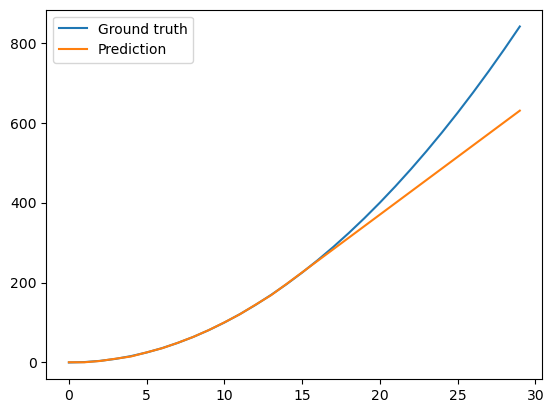

In [46]:
test(model, [0, 30], 1, loss_fn, device)

这里可以看到[0-17]范围内拟合效果是很好的，想要进一步增加拟合效果需要增加神经元数量或者其他改进